In [2]:
import os.path as osp
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from sklearn.cluster import DBSCAN
from torch_geometric.data import Data
import torch_geometric.transforms as ttr
from astropy import table as astropy_table

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.plotter import plot_data, plot_clusters, plot_fits_data


In [3]:
from typing import Any


class MPTDData(Data):
    def __init__(self, x = None, edge_index = None, edge_attr = None, y = None, pos = None, **kwargs):
        assert x is None
        super().__init__(x, edge_index, edge_attr, y, pos, **kwargs)

    @property
    def x(self):
        return self.pos
    
    def append(self, other):
        new_edge_index = torch.hstack([self.edge_index, other.edge_index]) \
                         if other.edge_index is not None and self.edge_index is not None else None
        new_edge_attr = torch.hstack([self.edge_attr, other.edge_attr]) \
                        if other.edge_attr is not None and self.edge_attr is not None else None
        
        return MPTDData(x=torch.vstack([self.x, other.x]), 
                        y=torch.hstack([self.y, other.y]), 
                        pos=torch.vstack([self.y, other.y]), 
                        edge_index=new_edge_index,
                        edge_attr=new_edge_attr
                        )    
 
    def getsplice(self, index):
        y = self.y[index] if self.y is not None else None
        pos = self.pos[index] if self.pos is not None else None

        return MPTDData(y=y, pos=pos)
    
    def __len__(self):
        if self.y is not None:
            return self.y.size(0)
        else:
            raise ValueError("The data object has no valid tensor for indexing.")   

class MPTDDataset:
    def __init__(self, filenames, keys, filters:dict, withsim=True) -> None:
        if type(filenames) is str:
            filenames = [filenames]
        filename = filenames[0]
        ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
        lastcolname = "PHA" if ismos else "TIME_RAW"
        keys_plus = keys + [lastcolname]
        raw_data = get_raw_data(filename, keys_plus, filters)
        for filename in filenames[1:]:
            ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
            lastcolname = "PHA" if ismos else "TIME_RAW"
            keys_plus = keys + [lastcolname]
            raw_data = astropy_table.vstack([raw_data, get_raw_data(filename, keys_plus, filters)])

        issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()
        self.groups = torch.from_numpy(np.array(raw_data[lastcolname]))
        self.groups[~issimulated] = -1

        if withsim:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                                 y = issimulated.long()).cuda()
        else:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                                 y = issimulated[~issimulated].long()).cuda()
            
        self.keys = keys

    def get_group(self, group):
        indices = self.groups == group
        return self.data.pos[indices]
    
    def list_groups(self):
        return torch.unique(self.groups)

class MPTDElaborator:
    def __init__(self, dataset:MPTDDataset, transformer, keys, model) -> None:
        self.dataset = dataset
        self.net_data = transformer(dataset.data)
        self.keys = keys
        self.model = model
        self.iterations = 0
        self.elaborated_data = torch.ones_like(self.net_data.x[:, 0].unsqueeze(-1))#torch.ones((1, self.net_data.x.shape[0]), device=self.net_data.x.device)

    def sizes(self):
        return self.elaborated_data.squeeze()
    
    def distances(self):
        return torch.norm(self.net_data.pos[self.net_data.edge_index[0]] - self.net_data.pos[self.net_data.edge_index[1]], dim=1)
    
    def forward(self, iterations=1):
        for _ in range(iterations):
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
        return self.sizes()
    
    def forward_plot(self, iterations, plot_every=1, plot_after = 0, max_threshold=0.5):
        sizes = self.forward(iterations=plot_after)
        # threshold = torch.quantile(sizes, quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        while self.iterations < iterations:
            plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                      keys=self.keys, title=f"iteration {self.iterations}", 
                      outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))
            sizes = self.forward(iterations=min(iterations - self.iterations, plot_every))
            # threshold = torch.quantile(sizes, quantile).item()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
        
        plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                  keys=self.keys, title=f"iteration {self.iterations}", 
                  outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))

        return sizes

    def auto_forward(self, rej_threshold, max_threshold):
        sizes = self.sizes()
        # threshold = torch.quantile(sizes, quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        old_len = mask.sum()
        self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
        self.iterations += 1
        self.elaborated_data /= self.elaborated_data.max()
        sizes = self.sizes()
        # threshold = torch.quantile(sizes, quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        new_len = mask.sum()
        while old_len - new_len > rej_threshold:
            old_len = new_len
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
            sizes = self.sizes()
            # threshold = torch.quantile(sizes, quantile).item()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
            new_len = mask.sum()
        return self.sizes()

class MPTDClusterer:
    def __init__(self, algorithm, max_threshold):
        self.max_threshold = max_threshold
        self.algorithm = algorithm

    def mask(self, elaborator:MPTDElaborator):
        sizes = elaborator.sizes()
        threshold = min(sizes.mean().item(), self.max_threshold)
        mask = sizes >= threshold
        return mask

    def mask_data(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        return masked_data
    
    def cluster(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        labels = self.algorithm.fit_predict(masked_data.pos)
        labels_full = np.full((elaborator.net_data.pos.shape[0],), -1)
        labels_full[mask.cpu()] = labels

        return labels_full
    
class MPTDScorer:
    def __init__(self, elaborator:MPTDElaborator):
        self.dataset    = elaborator.dataset
        self.elaborator = elaborator
        self.labels = None

    def predict_labels(self, clusterer:MPTDClusterer):
        self.labels = clusterer.cluster(self.elaborator)
        return self.labels

    def fluence_vs_success(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.dataset.data.y.cpu().bool()], self.dataset.groups[self.dataset.data.y.cpu().bool()], self.dataset.data.pos[self.labels >= 0])
    
    def cluster_accuracy(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].float().mean()

    def num_true_positives(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].sum()

    def num_false_positives(self):
        assert self.labels is not None
        return (1 - count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1]).sum()

def count_and_check_coordinates(tensors_A, tensor_B):
    # Initialize lists to store the number of points and presence information for each tensor A
    num_points_list = []
    contains_matching_coordinates_list = []

    # Perform element-wise comparison for each tensor in tensors_A
    for tensor_A in tensors_A:
        # Broadcast tensor_B to have the same shape as tensor_A
        expanded_B = tensor_B.unsqueeze(0)  # Shape: (1, B_points, 3)
        expanded_B = expanded_B.expand(tensor_A.shape[0], -1, -1)  # Shape: (A_points, B_points, 3)

        # Perform element-wise comparison to check for matching coordinates
        matched_coordinates = torch.all(tensor_A.unsqueeze(1) == expanded_B, dim=-1)

        # Use torch.any() to check if any coordinate in A matches any coordinate in B for this tensor A
        contains_matching_coordinates = torch.any(matched_coordinates, dim=1)

        # Append the number of points and presence information to their respective lists
        num_points_list.append(tensor_A.shape[0])
        contains_matching_coordinates_list.append(contains_matching_coordinates)

    # Concatenate the lists to create tensors
    num_points_in_A = torch.tensor(num_points_list, dtype=torch.int32).unsqueeze(-1)

    contains_matching_coordinates_tensor = torch.tensor([elems.any(dim=-1) for elems in contains_matching_coordinates_list], dtype=bool).unsqueeze(1)

    # Combine the information about the number of points and matching coordinates into a single tensor
    result_tensor = torch.cat((num_points_in_A, contains_matching_coordinates_tensor.int()), dim=1)

    return result_tensor

def count_and_check_coordinates_grouped(tensor_coordinates, labels, tensor_B):
    unique_labels = np.unique(labels)
    tensors_A = []

    for label in unique_labels:
        # Get the coordinates for the current label
        mask = labels == label
        coordinates_for_label = tensor_coordinates[mask]

        # Append the tensor with coordinates for this label to the list of tensors A
        tensors_A.append(coordinates_for_label)

    # Apply the function for each tensor in tensors_A and store the results in a list
    results = count_and_check_coordinates(tensors_A, tensor_B)

    return results

In [4]:
def find_common_parts(strings):
    if not strings:
        return ""

    common_parts = ""
    for chars_at_position in zip(*strings):
        if all(char == chars_at_position[0] for char in chars_at_position):
            common_parts += chars_at_position[0]

    return common_parts

In [5]:
def single_file_analysis(filenames, keys, k, layers, quantile, max_threshold, filters, min_samples, withsim=True, save_every=None, max_time_interval = np.inf):
    dataset = MPTDDataset(filenames, keys, filters, withsim=withsim)
    transformer = ttr.KNNGraph(k=k, force_undirected=True)
    model = SimpleMessage()
    elaborator = MPTDElaborator(dataset,transformer,keys,model)

    # elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)
    # eps = elaborator.distances().median().item()/2
    # eps = torch.quantile(elaborator.distances(), quantile).item()
    eps = elaborator.distances().max().item()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
    scorer = MPTDScorer(elaborator)
    if save_every is None:
        save_every = np.inf
    
    results = pd.DataFrame()

    start_time = time.time()
    while scorer.elaborator.iterations < layers:
        scorer.elaborator.forward(iterations=min(save_every, layers - scorer.elaborator.iterations))
        labels = scorer.predict_labels(clusterer)
        for group in np.unique(scorer.labels):
            if group < 0: continue
            mask = scorer.labels == group
            group_times = scorer.elaborator.dataset.data.pos[mask, 2].cpu()
            time_interval = group_times.max() - group_times.min()
            if time_interval > max_time_interval:
                #print(f"removed group {group}")
                scorer.labels[mask] = -1
        df = pd.DataFrame(scorer.fluence_vs_success().float(), columns=["Fluence", "Detected"])
        # if type(filenames) is not str and len(filenames) > 1:
        #     filenames = find_common_parts(filenames)
        df["File"] = np.full(df["Fluence"].shape, filenames)
        df["Accuracy"] = np.full_like(df["Fluence"], scorer.cluster_accuracy())
        df["Iteration"] = np.full_like(df["Fluence"], scorer.elaborator.iterations)
        end_time = time.time()
        elapsed_time = end_time - start_time
        df["Time"] = elapsed_time
        results = pd.concat([results, df])
    return results

In [6]:
def auto_single_file_analysis(filenames, keys, k, rej_thresholds, quantile, max_threshold, filters, min_samples, withsim=True, save_every=None, max_time_interval = np.inf):
    assert len(rej_thresholds) == 2, "'rej_thresholds' should only contain two values: starting threshold and ending threshold."
    assert rej_thresholds[0] > rej_thresholds[1], "'rej_thresholds' must be ordered from greatest to smallest."
    dataset = MPTDDataset(filenames, keys, filters, withsim=withsim)
    transformer = ttr.KNNGraph(k=k, force_undirected=True)
    model = SimpleMessage()
    elaborator = MPTDElaborator(dataset,transformer,keys,model)

    # elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)
    # eps = elaborator.distances().median().item()/2
    # eps = torch.quantile(elaborator.distances(), quantile).item()
    eps = elaborator.distances().max().item()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
    scorer = MPTDScorer(elaborator)
    if save_every is None:
        save_every = np.inf
    
    results = pd.DataFrame()

    start_time = time.time()
    for rej_threshold in [i for i in range(*rej_thresholds, -save_every)] + [rej_thresholds[1]]:
        scorer.elaborator.auto_forward(rej_threshold, max_threshold)
        labels = scorer.predict_labels(clusterer)
        for group in np.unique(scorer.labels):
            if group < 0: continue
            mask = scorer.labels == group
            group_times = scorer.elaborator.dataset.data.pos[mask, 2].cpu()
            time_interval = group_times.max() - group_times.min()
            if time_interval > max_time_interval:
                #print(f"removed group {group}")
                scorer.labels[mask] = -1
        df = pd.DataFrame(scorer.fluence_vs_success().float(), columns=["Fluence", "Detected"])
        # if type(filenames) is not str and len(filenames) > 1:
        #     filenames = find_common_parts(filenames)
        df["File"] = np.full(df["Fluence"].shape, filenames)
        df["Accuracy"] = np.full_like(df["Fluence"], scorer.cluster_accuracy())
        df["Rejection"] = np.full_like(df["Fluence"], rej_threshold)
        df["Iteration"] = np.full_like(df["Fluence"], scorer.elaborator.iterations)
        df["True Pos"] = np.full_like(df["Fluence"], scorer.num_true_positives())
        df["False Pos"] = np.full_like(df["Fluence"], scorer.num_false_positives())
        end_time = time.time()
        elapsed_time = end_time - start_time
        df["Time"] = elapsed_time
        results = pd.concat([results, df])
    return results

In [7]:
keys = ["X", "TIME", "Y"]
k = 8
layers = 200
save_every = 10
quantile = 0.999
max_threshold = 0.90
filters = {"FLAG": (0,4)}
withsim = True
min_samples = 5
max_time_interval = 10_000
rej_thresholds = (100, 0)

In [8]:
import os, os.path as osp
from glob import glob
import random
import datetime
from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table

In [9]:
# n = 100
# # Set a fixed seed for replicability
# seed_value = 43
# random.seed(seed_value)
# basedir = osp.join("test.onD", "Icaro", "raw")
# filenames = glob(osp.join(basedir, "0*", "pps", "P*EVLF0000.FTZ"))
# # Filter out any non-Full Window observation fo MOS cameras to preserve event density
# filenames = [filename for filename in filenames if filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow']
# filenames = random.sample(filenames, n)

In [10]:
n = 500
# Set a fixed seed for replicability
seed_value = 43
random.seed(seed_value)
basedir = osp.join("test.onD", "Icaro", "raw")
filenames = glob(osp.join(basedir, "0*", "pps", "P*EVLF0000.FTZ"))
# Filter out any non-Full Window observation fo MOS cameras to preserve event density
filenames = [filename for filename in filenames if filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow']
filenames_pd = pd.DataFrame({"Filename": filenames})
filenames_pd["Size"] = [osp.getsize(filename) for filename in filenames_pd["Filename"]]
filenames_pd = filenames_pd.loc[filenames_pd["Size"] > 0]
filenames_pd = filenames_pd.sort_values(by="Size")
filenames = filenames_pd["Filename"][:n].to_numpy()

# filenames = random.sample(filenames, n)

In [11]:
filenames_pd.iloc[:n]

,Filename,Size
2362,test.onD\Icaro\raw\0725310146\pps\P0725310146M...,230211
2392,test.onD\Icaro\raw\0725310156\pps\P0725310156M...,231117
2293,test.onD\Icaro\raw\0725300154\pps\P0725300154M...,236833
2380,test.onD\Icaro\raw\0725310152\pps\P0725310152M...,238121
2287,test.onD\Icaro\raw\0725300152\pps\P0725300152M...,238162
...,...,...
3723,test.onD\Icaro\raw\0747390151\pps\P0747390151M...,731909
372,test.onD\Icaro\raw\0673002349\pps\P0673002349M...,732634
2936,test.onD\Icaro\raw\0742340201\pps\P0742340201M...,732909
5870,test.onD\Icaro\raw\0785110901\pps\P0785110901M...,733781


In [12]:
# with fits.open("DeLuca_2021_sources.fit") as ADL_sources:
#     ADL_sources_pd = Table(ADL_sources[1].data).to_pandas()
# basedir = osp.join("test.onD", "Icaro", "raw")
# filename_patterns = [osp.join(basedir, f"{ObsID:010}", "pps", "P*EVLF0000.FTZ") for ObsID in ADL_sources_pd["ObsID"]]
# filenames = []
# print(len(filename_patterns))
# for filename_pattern in filename_patterns:
#     new_filenames = list(glob(filename_pattern))
#     for filename in new_filenames:
#         assert filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow', f"file '{filename}' has window mode {fits.open(filename)[0].header['SUBMODE']}"
#     print(new_filenames)
#     filenames += new_filenames
# filenames, filename_patterns

In [12]:
outfile = osp.join("prove", str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".csv")

In [13]:
# df = pd.DataFrame()
first = True
for filename in tqdm(filenames):
    # progress_bar = tqdm(desc=str(filename), total=(layers//save_every if save_every is not None else None))
    # res = single_file_analysis(filename, keys, k, layers, 
    #                            quantile, max_threshold, filters, 
    #                            min_samples, withsim, save_every=save_every, max_time_interval=max_time_interval)
    res = auto_single_file_analysis(filename, keys, k, rej_thresholds, 
                               quantile, max_threshold, filters, 
                               min_samples, withsim, save_every=save_every, max_time_interval=max_time_interval)
    # df = pd.concat([df, res])
    res.to_csv(outfile, mode='a', header=first, index=False)
    torch.cuda.empty_cache()
    first=False

100%|██████████| 500/500 [02:27<00:00,  3.40it/s]


In [14]:
# df.to_csv("prima_prova.csv")

In [15]:
# filenames[13]

In [16]:
# dataset = MPTDDataset(filenames[13], keys, filters, withsim)
# print("plotting")
# plot_data(dataset.data.x.cpu(), (0.01,0.1), dataset.data.y.cpu().bool(),keys)

In [17]:
df = pd.read_csv(outfile)

In [13]:
df = pd.read_csv(r"prove\2023-07-24_16-36-14.csv")

In [14]:
# df = pd.read_csv(r"prove\2023-07-21_17-49-52.csv")

In [15]:
# df.groupby("File").last()

In [16]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# lvsa = pd.DataFrame()

# df = df.set_index("Fluence")

# for layer in df["Iteration"].unique():
#     df_layer = df[df["Iteration"] == layer]
#     bins = pd.qcut(df_layer.index, q=10)

#     mean_values = df_layer["Detected"].groupby(bins).mean()

#     # if 40 <= layer <= 80: mean_values.plot(figsize=(12,6), ax=ax1, label=f"{layer} iterations")
#     mean_values.plot(figsize=(12,6), ax=ax1, label=f"{layer} iterations")

#     tmp = df_layer.groupby("File").mean().reset_index()
#     accuracies = tmp["Accuracy"]
#     filenames = tmp["File"]
#     new_rows = pd.DataFrame({"Layers": np.full_like(accuracies, layer), "Accuracy": accuracies, "File": filenames})
#     lvsa = pd.concat([lvsa, new_rows], ignore_index=True)
#     # lvsa.append({"Layers": layers, "Mean Accuracy": df_layer.groupby("File").mean().reset_index()["Accuracy"].mean()*100}, ignore_index=True)

# df = df.reset_index()

# ax1.set_xlabel('Fluence')
# ax1.set_ylabel('Detection Fraction')
# ax1.set_title('Detection Fraction vs. Fluence')
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# lvsa.plot(kind="scatter", x="Layers", y="Accuracy", ax=ax2)
# # for file_name, group in lvsa.groupby('File'):
# #     ax2.plot(group['Layers'], group['Accuracy'], label=file_name, marker='o')
# lvsa_means = lvsa[["Layers","Accuracy"]].groupby("Layers").mean().reset_index()
# lvsa_means["std"] = lvsa[["Layers","Accuracy"]].groupby("Layers").std().to_numpy()

# ax2.errorbar(lvsa_means["Layers"], lvsa_means["Accuracy"], yerr=lvsa_means["std"], label="mean accuracy", c="red", alpha=0.6)
# ax2.set_xlabel('# Iterations')
# ax2.set_ylabel('Cluster Accuracy')
# ax2.set_title("Cluster Accuracy vs. Number of Iterations")
# ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# plt.show()


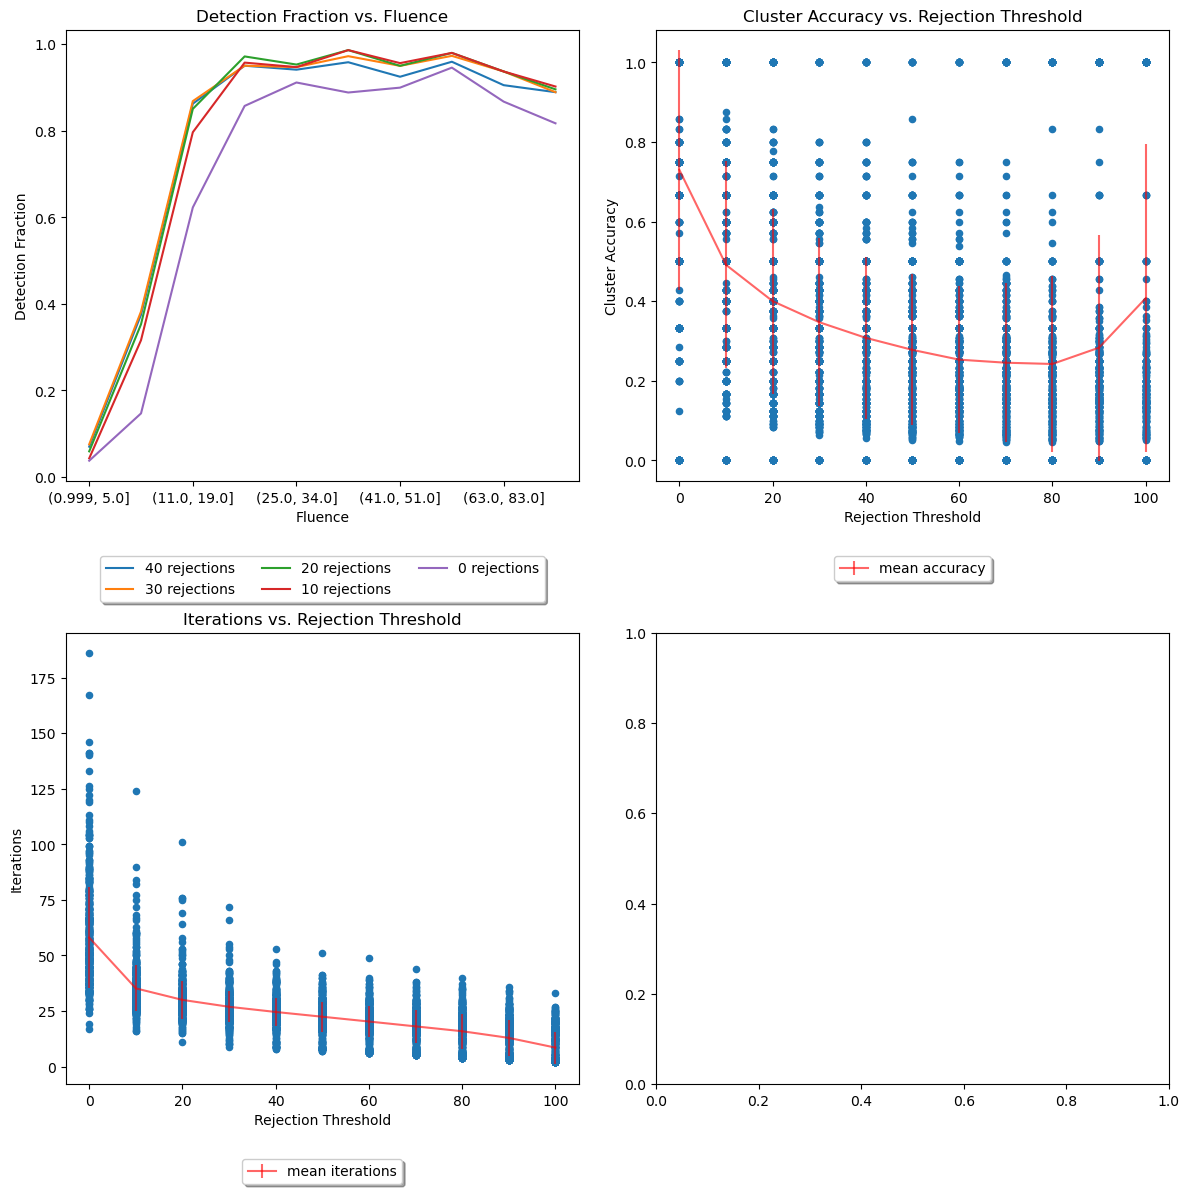

In [17]:
figsize = (12,12)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

rtvsa = pd.DataFrame()

df = df.set_index("Fluence")

for rej_threshold in df["Rejection"].unique():
    df_layer = df[df["Rejection"] == rej_threshold]
    bins = pd.qcut(df_layer.index, q=10)

    mean_values = df_layer["Detected"].groupby(bins).mean()

    if rej_threshold <= 40: mean_values.plot(ax=ax1, label=f"{int(rej_threshold)} rejections")
    # mean_values.plot(ax=ax1, label=f"{int(rej_threshold)} rejections")

    tmp = df_layer.groupby("File").mean().reset_index()
    accuracies = tmp["Accuracy"]
    filenames = tmp["File"]
    iterations = tmp["Iteration"]
    true_positives = tmp["True Pos"]
    false_positives = tmp["False Pos"]
    new_rows = pd.DataFrame({"Rejection Threshold": np.full_like(accuracies, rej_threshold), 
                             "Iterations": iterations, 
                             "Accuracy": accuracies,
                             "True Positives": true_positives,
                             "False Positives": false_positives,
                             "File": filenames})
    rtvsa = pd.concat([rtvsa, new_rows], ignore_index=True)
    # lvsa.append({"Rejection Threshold": layers, "Mean Accuracy": df_layer.groupby("File").mean().reset_index()["Accuracy"].mean()*100}, ignore_index=True)

df = df.reset_index()

ax1.set_xlabel('Fluence')
ax1.set_ylabel('Detection Fraction')
ax1.set_title('Detection Fraction vs. Fluence')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

rtvsa.plot(kind="scatter", x="Rejection Threshold", y="Accuracy", ax=ax2)
# for file_name, group in lvsa.groupby('File'):
#     ax2.plot(group['Rejection Threshold'], group['Accuracy'], label=file_name, marker='o')
rtvsa_means = rtvsa[["Rejection Threshold","Accuracy"]].groupby("Rejection Threshold").mean().reset_index()
rtvsa_means["std"] = rtvsa[["Rejection Threshold","Accuracy"]].groupby("Rejection Threshold").std().to_numpy()

ax2.errorbar(rtvsa_means["Rejection Threshold"], rtvsa_means["Accuracy"], yerr=rtvsa_means["std"], label="mean accuracy", c="red", alpha=0.6)
ax2.set_xlabel('Rejection Threshold')
ax2.set_ylabel('Cluster Accuracy')
ax2.set_title("Cluster Accuracy vs. Rejection Threshold")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

rtvsa.plot(kind="scatter", x="Rejection Threshold", y="Iterations", ax=ax3)
rtvsa_means = rtvsa[["Rejection Threshold","Iterations"]].groupby("Rejection Threshold").mean().reset_index()
rtvsa_means["std"] = rtvsa[["Rejection Threshold","Iterations"]].groupby("Rejection Threshold").std().to_numpy()

ax3.errorbar(rtvsa_means["Rejection Threshold"], rtvsa_means["Iterations"], yerr=rtvsa_means["std"], label="mean iterations", c="red", alpha=0.6)
ax3.set_xlabel('Rejection Threshold')
ax3.set_ylabel('Iterations')
ax3.set_title("Iterations vs. Rejection Threshold")
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


In [33]:
df[df["Rejection"] == 10].groupby("File").first()[["True Pos", "False Pos","Accuracy", "Iteration"]].sort_values(by="True Pos")

,True Pos,False Pos,Accuracy,Iteration
File,,,,
test.onD\Icaro\raw\0725300156\pps\P0725300156M2S003MIEVLF0000.FTZ,0.0,7.0,0.000000,50.0
test.onD\Icaro\raw\0748590131\pps\P0748590131M1S001MIEVLF0000.FTZ,0.0,3.0,0.000000,45.0
test.onD\Icaro\raw\0725310154\pps\P0725310154M2S003MIEVLF0000.FTZ,0.0,6.0,0.000000,48.0
test.onD\Icaro\raw\0747400150\pps\P0747400150M2S002MIEVLF0000.FTZ,0.0,4.0,0.000000,29.0
test.onD\Icaro\raw\0725310133\pps\P0725310133M2S003MIEVLF0000.FTZ,0.0,2.0,0.000000,35.0
...,...,...,...,...
test.onD\Icaro\raw\0761090701\pps\P0761090701M1S007MIEVLF0000.FTZ,6.0,1.0,0.857143,33.0
test.onD\Icaro\raw\0742830141\pps\P0742830141M1S001MIEVLF0000.FTZ,6.0,3.0,0.666667,25.0
test.onD\Icaro\raw\0721830301\pps\P0721830301M1S001MIEVLF0000.FTZ,6.0,2.0,0.750000,28.0


In [23]:
number_of_false_positives = (df.groupby("File").sum()["Detected"] * (1 - df[df["Rejection"]==10].groupby("File").first()["Accuracy"])).to_numpy().sum()

In [24]:
number_of_false_positives

4881.69840254

In [37]:
df.columns

Index(['Fluence', 'Detected', 'File', 'Accuracy', 'Rejection', 'Iteration',
       'True Pos', 'False Pos', 'Time'],
      dtype='object')

plotting


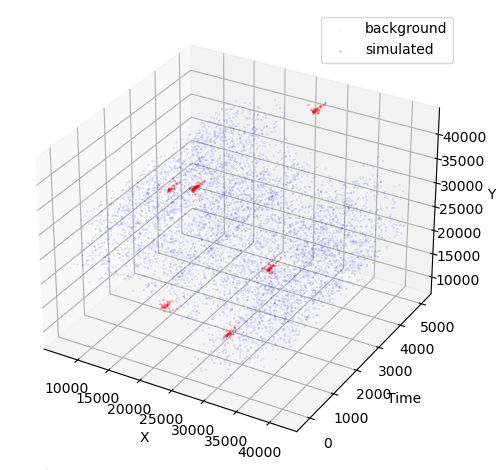

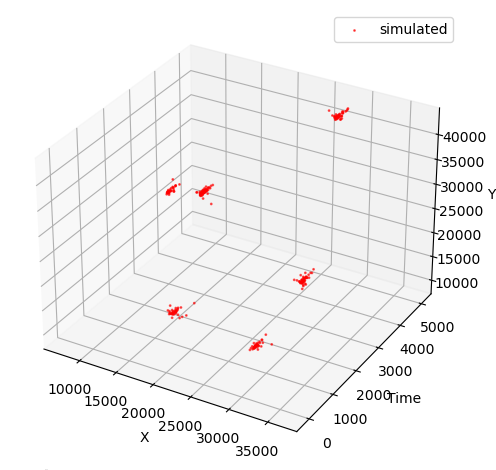

In [59]:
from astropy.wcs import WCS
from astropy import units as u
# Create a SkyCoord object with the given coordinates and frame
#filename = df[df["Iteration"]==layers].groupby("File").first()["Time"].idxmax()
filename= r"test.onD\Icaro\raw\0725300156\pps\P0725300156M2S003MIEVLF0000.FTZ"
filename, layers = df[df["Rejection"] == 10].groupby("File").first()[["True Pos", "False Pos","Accuracy", "Iteration"]]\
    .sort_values(by="True Pos").reset_index().iloc[-4][["File", "Iteration"]]
layers = int(layers)
header = fits.open(filename)[0].header
dataset = MPTDDataset(filename, keys, filters, withsim)
print("plotting")
plot_data(dataset.data.x.cpu(), (0.01,0.1), dataset.data.y.cpu().bool(),keys)
plot_data(dataset.data.x.cpu(), (0.0,1), dataset.data.y.cpu().bool(),keys)

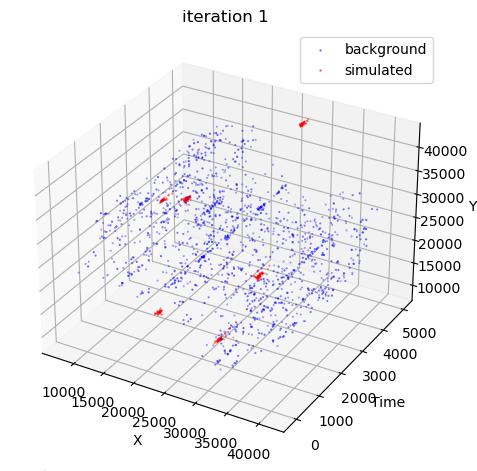

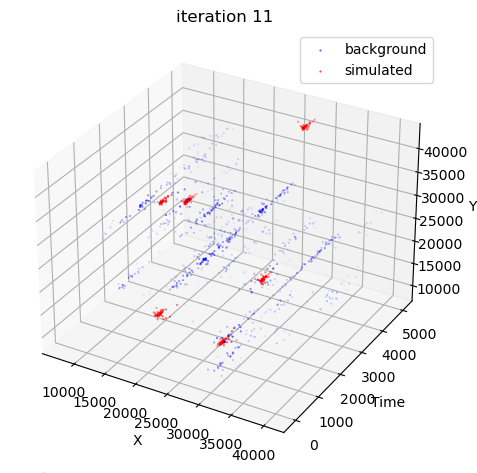

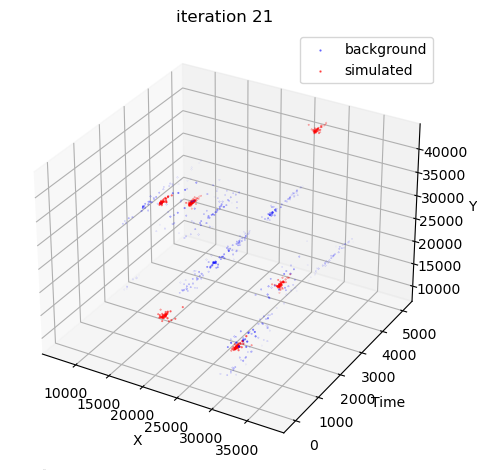

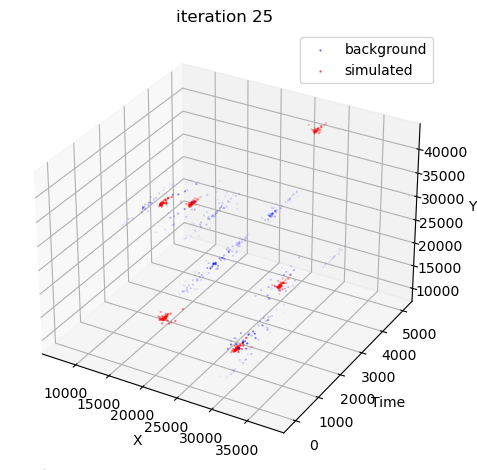

tensor([0.2153, 0.2223, 0.2713,  ..., 0.0007, 0.0012, 0.0010], device='cuda:0')

In [60]:
transformer = ttr.KNNGraph(k=k, force_undirected=True)
model = SimpleMessage()
elaborator = MPTDElaborator(dataset,transformer,keys,model)

# elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)
# eps = elaborator.distances().median().item()/2
# eps = torch.quantile(elaborator.distances(), quantile).item()
eps = elaborator.distances().max().item()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
scorer = MPTDScorer(elaborator)
if save_every is None:
    save_every = np.inf

scorer.elaborator.forward_plot(iterations=layers, plot_every=10, plot_after=1, max_threshold=max_threshold)

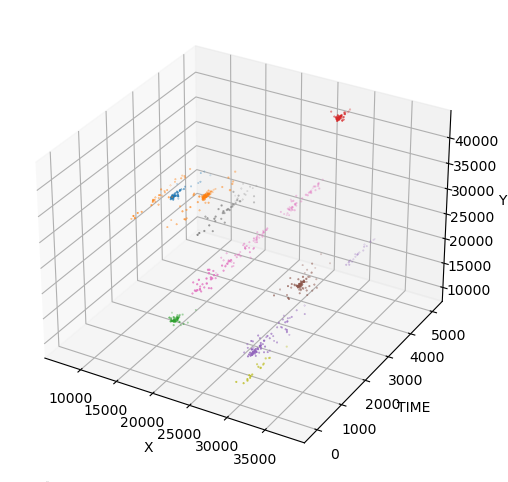

In [61]:
labels = clusterer.cluster(elaborator)
mask = clusterer.mask(elaborator).cpu()
masked_data = clusterer.mask_data(elaborator).cpu()
plot_clusters(masked_data.pos, elaborator.sizes().cpu()[mask], labels[mask].squeeze(), keys, figsize=(6,6))

In [ ]:
fits.open('test.onD\\Icaro\\raw\\0761100101\\pps\\P0761100101PNS003PIEVLF0000.FTZ')[0].header